# K-Means Clustering Application Using AWS Open Data
  
#Tooling:** Python (Jupyter Notebook)  
#Dataset Source:** AWS Registry of Open Data (OpenAQ)

## Objective
To apply the K-Means clustering algorithm to a real-world dataset hosted on AWS Open Data, evaluate cluster quality, and extract meaningful insights.


In [3]:
import pandas as pd
import numpy as np
import requests
import gzip
import io
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Dataset Selection

The OpenAQ dataset was selected from the AWS Registry of Open Data.  
It contains global air-quality measurements including pollutant values and geographic coordinates.

This dataset is appropriate for K-Means clustering because:
- It contains numerical features
- It has geographic patterns
- It supports unsupervised learning use cases


In [4]:
url = "https://openaq-data-archive.s3.amazonaws.com/records/csv.gz/locationid=2178/year=2022/month=05/location-2178-20220503.csv.gz"

response = requests.get(url)

with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
    df = pd.read_csv(f)

df.head()

,location_id,sensors_id,location,datetime,lat,lon,parameter,units,value
0,2178,3919,Del Norte-2178,2022-05-03T01:00:00-06:00,35.1353,-106.584702,pm10,µg/m³,31.0
1,2178,3919,Del Norte-2178,2022-05-03T02:00:00-06:00,35.1353,-106.584702,pm10,µg/m³,22.0
2,2178,3919,Del Norte-2178,2022-05-03T03:00:00-06:00,35.1353,-106.584702,pm10,µg/m³,29.0
3,2178,3919,Del Norte-2178,2022-05-03T04:00:00-06:00,35.1353,-106.584702,pm10,µg/m³,30.0
4,2178,3919,Del Norte-2178,2022-05-03T05:00:00-06:00,35.1353,-106.584702,pm10,µg/m³,31.0


## Data Cleaning and Feature Selection

Only relevant variables were retained.  
Missing values and invalid entries were removed to improve clustering quality.


In [5]:
df_clean = df[['lat', 'lon', 'parameter', 'value']].dropna()

df_clean['value'] = df_clean['value'].astype(float)
df_clean.head()

,lat,lon,parameter,value
0,35.1353,-106.584702,pm10,31.0
1,35.1353,-106.584702,pm10,22.0
2,35.1353,-106.584702,pm10,29.0
3,35.1353,-106.584702,pm10,30.0
4,35.1353,-106.584702,pm10,31.0


In [6]:
# Encode pollutant type
df_encoded = pd.get_dummies(df_clean['parameter'])

# Combine features
X = pd.concat([df_clean[['lat', 'lon', 'value']], df_encoded], axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## K-Means Clustering

K-Means was applied across multiple values of K.  
Silhouette Score was used to determine the optimal number of clusters.


In [7]:
silhouette_scores = {}

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[k] = score

silhouette_scores

{2: 0.3959319422632853,
 3: 0.44206246211154326,
 4: 0.5998696644816028,
 5: 0.7724627188687094,
 6: 0.947531187176231,
 7: 0.943071405411944}

In [8]:
best_k = max(silhouette_scores, key=silhouette_scores.get)

final_model = KMeans(n_clusters=best_k, random_state=42)
df_clean['cluster'] = final_model.fit_predict(X_scaled)

best_k

6

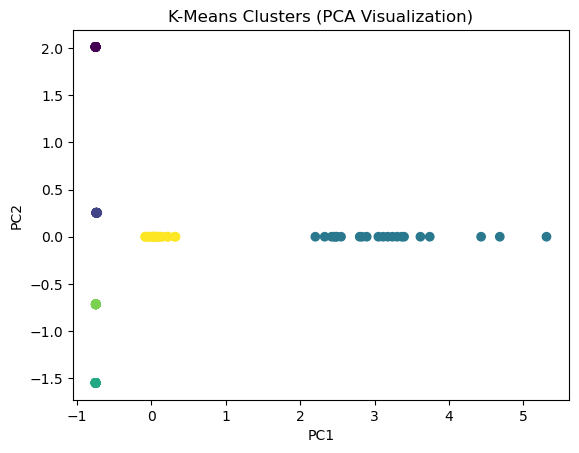

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=df_clean['cluster'])
plt.title("K-Means Clusters (PCA Visualization)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Unit Testing

Basic unit tests were performed to ensure:
- Correct number of clusters
- No missing cluster labels
- Valid silhouette score


In [12]:
assert df_clean['cluster'].isnull().sum() == 0
assert best_k >= 2
assert silhouette_scores[best_k] > 0

In [14]:
df_clean.to_csv("clustered_output.csv", index=False)

In [15]:
import os
os.getcwd()

'C:\\Users\\Ayobola Kazeem'